## `scikit-learn`

In [374]:
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [408]:
class Node:
    def __init__(self, value=None, feature=None, threshold=None, left=None, right=None):
        self.value = value          # For leaf nodes: prediction value
        self.feature = feature      # Feature index to split on
        self.threshold = threshold  # Threshold value for split
        self.left = left            # Left child node
        self.right = right          # Right child node
    
    def is_leaf(self):
        return self.value is not None

class SimpleDecisionTreeRegressor:
    def __init__(self, max_depth=3, min_samples_split=2):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.root = None
    
    def fit(self, X, y):
        self.root = self._build_tree(X, y, depth=0)
        return self
    
    def _build_tree(self, X, y, depth):
        n_samples, n_features = X.shape
        
        # Stopping conditions: make a leaf node
        if depth >= self.max_depth or n_samples < self.min_samples_split or len(np.unique(y)) == 1:
            return Node(value=np.mean(y))
        
        # Find best split
        best_feature, best_threshold = self._find_best_split(X, y)
        
        # If no good split found, make a leaf
        if best_feature is None:
            return Node(value=np.mean(y))
        
        # Split the data
        left_mask = X[:, best_feature] <= best_threshold
        right_mask = ~left_mask
        
        # Recursively build left and right subtrees
        left_child = self._build_tree(X[left_mask], y[left_mask], depth + 1)
        right_child = self._build_tree(X[right_mask], y[right_mask], depth + 1)
        
        return Node(feature=best_feature, threshold=best_threshold, 
                   left=left_child, right=right_child)
    
    def _find_best_split(self, X, y):
        n_samples, n_features = X.shape
        
        if n_samples <= 1:
            return None, None
        
        best_gain = -np.inf
        best_feature = None
        best_threshold = None
        
        # Current variance (what we're trying to reduce)
        parent_variance = np.var(y)
        
        # Try each feature
        for feature_idx in range(n_features):
            feature_values = X[:, feature_idx]
            thresholds = np.unique(feature_values)
            
            # Try each unique value as a threshold
            for threshold in thresholds:
                # Split data
                left_mask = feature_values <= threshold
                right_mask = ~left_mask
                
                # Skip if split creates empty node
                if np.sum(left_mask) == 0 or np.sum(right_mask) == 0:
                    continue
                
                # Calculate weighted variance of children
                y_left, y_right = y[left_mask], y[right_mask]
                n_left, n_right = len(y_left), len(y_right)
                print(n_left, n_right)
                
                weighted_variance = (n_left / n_samples) * np.var(y_left) + \
                                   (n_right / n_samples) * np.var(y_right)
                
                # Variance reduction (gain)
                gain = parent_variance - weighted_variance
                
                # Update best split if this is better
                if gain > best_gain:
                    best_gain = gain
                    best_feature = feature_idx
                    best_threshold = threshold
        
        return best_feature, best_threshold
    
    def predict(self, X):
        return np.array([self._predict_single(x, self.root) for x in X])
    
    def _predict_single(self, x, node):
        # If leaf node, return its value
        if node.is_leaf():
            return node.value
        
        # Otherwise, go left or right
        if x[node.feature] <= node.threshold:
            return self._predict_single(x, node.left)
        else:
            return self._predict_single(x, node.right)

In [409]:
class SimpleGradientBoosting:
    def __init__(self, n_estimators=100, learning_rate=0.1, max_depth=3, min_samples_split=2):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.trees = []
        self.initial_prediction = None
    
    def fit(self, X, y):
        # Step 1: Initialize with mean
        self.initial_prediction = np.mean(y)
        current_predictions = np.full(len(y), self.initial_prediction)
        
        # Step 2: Build trees iteratively
        for i in range(self.n_estimators):
            # Calculate residuals
            residuals = y - current_predictions
            
            # Train tree on residuals
            #tree = DecisionTreeRegressor(max_depth=self.max_depth)
            tree = SimpleDecisionTreeRegressor(max_depth=self.max_depth, min_samples_split=2)
            tree.fit(X, residuals)
            
            # Update predictions
            tree_predictions = tree.predict(X)
            current_predictions += self.learning_rate * tree_predictions
            
            # Store tree
            self.trees.append(tree)
        
        return self
    
    def predict(self, X):
        # Start with initial prediction
        predictions = np.full(len(X), self.initial_prediction)
        
        # Add contribution from each tree
        for tree in self.trees:
            predictions += self.learning_rate * tree.predict(X)
        
        return predictions

In [411]:
# Generate sample data
np.random.seed(42)
n, p = 10, 1  # n samples, p features, k targets

X = np.random.uniform(size=n, low=-1, high=1).reshape(-1,1)

## Set y
y = np.sign(X).reshape((n,)) + 0.1*np.random.normal(size=n)

# # Train our simple tree
tree = SimpleDecisionTreeRegressor(max_depth=20, min_samples_split=0)
tree.fit(X, y)

# # Make predictions
y_hat_tree = tree.predict(X)

# # Train our simple gradient boosting
# gb = SimpleGradientBoosting(n_estimators=100, learning_rate=0.1, max_depth=3)
# gb.fit(X, y)

# # Make predictions
# y_hat_gb = gb.predict(X)

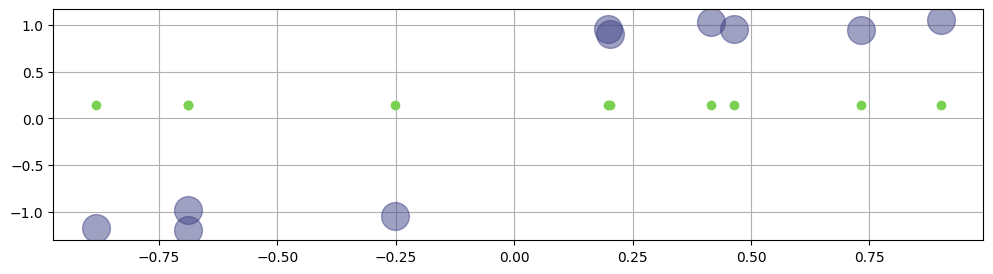

In [412]:
cmap = cm.viridis
fig, ax =plt.subplots(figsize=(12,3))
ax.plot(X[:], y, "o", alpha=0.5, color=cmap(0.2), ms=20)
ax.plot(X[:], y_hat_tree, "o", alpha=1, color=cmap(0.8))
#ax.plot(X[:], y_hat_gb, "+", alpha=0.5, color=cmap(0.8))
ax.grid()

## Gradient Boosting for [X[t], y[t]]
* X[t], y[t] are lists or dicts
* `class Node` if node is a leaf, value is a list or a dict
* Build `SimpleDecisionTreeRegressor`
* `_find_best_split(self, X_list, y_list)` returns `best_feature, best_threshold`
* `_predict_single` returns a list of predicted values from a feature

### Best Split

In [61]:
def _find_best_split(X, y):
    n_samples, n_features = X.shape
    
    if n_samples <= 1:
        return None, None
    
    best_gain = -np.inf
    best_feature = None
    best_threshold = None
    
    # Current variance (what we're trying to reduce)
    parent_variance = np.var(y)
    
    # Try each feature
    for feature_idx in range(n_features):
        feature_values = X[:, feature_idx]
        thresholds = np.unique(feature_values)
        
        # Try each unique value as a threshold
        for threshold in thresholds:
            # Split data
            left_mask = feature_values <= threshold
            right_mask = ~left_mask
            
            # Skip if split creates empty node
            if np.sum(left_mask) == 0 or np.sum(right_mask) == 0:
                continue
            
            # Calculate weighted variance of children
            y_left, y_right = y[left_mask], y[right_mask]
            n_left, n_right = len(y_left), len(y_right)
            
            weighted_variance = (n_left / n_samples) * np.var(y_left) + \
                               (n_right / n_samples) * np.var(y_right)
            
            # Variance reduction (gain)
            gain = parent_variance - weighted_variance
            
            # Update best split if this is better
            if gain > best_gain:
                best_gain = gain
                best_feature = feature_idx
                best_threshold = threshold
    
    return best_feature, best_threshold

In [333]:
# Generate sample data
#np.random.seed(42)
n, p = 100, 2 # n samples, p features
T = 2

X_list = []
y_list = []

for t in range(T):
    X = np.random.uniform(size=n*p, low=-1, high=1).reshape(n,p)
    y = np.sum(np.sign(X), axis=1) + 0.1*np.random.randn(n) 
    y = y*np.sign(np.random.uniform(size=1, low=-5, high=5)[0])

    X_list.append(X)
    y_list.append(y)

In [334]:
y

array([ 0.04365916,  1.92740384, -0.00481838, -0.03976955, -0.1584413 ,
       -0.01388684, -2.15136846,  1.94441222, -2.12449015,  0.08003478,
        1.95713909,  1.98419409,  0.11623319, -0.08038206, -0.1555609 ,
        0.11700326,  2.05138126, -1.85944225,  0.20987478,  0.01185896,
       -2.04048134,  1.99638043,  0.09130082,  0.10098335,  0.07786606,
       -1.9890795 , -1.9431903 ,  2.00069695, -2.26710757, -0.07141063,
       -0.05930141, -0.01947474,  1.88250024,  2.06201327, -1.93344358,
       -0.08192494,  0.00415007, -1.99563718, -0.12166052,  1.83955845,
        0.07646804,  2.17143697, -1.91403632,  2.06024618,  0.01680087,
        0.12379141, -0.06343853, -0.0642629 ,  0.08632113, -0.00725965,
       -2.14231139, -1.97986951,  1.84392304,  1.90954573, -1.98985325,
       -2.06956002,  0.14530312, -1.91391071,  0.05525386, -0.05031331,
       -2.07249567,  0.02153953, -0.06657041,  0.08289992,  1.86339683,
        2.017847  , -0.00639351, -0.06048776,  2.0744119 ,  2.01

In [358]:
%%time
best_gain = -np.inf
best_feature = None
best_threshold = None

parent_variance = np.mean([np.var(y_list[t]) for t in range(T)])
w_var = []

# Try each feature
for j in range(p):
    feature_values = np.array([X_list[t][:, j] for t in range(T)]).flatten()
    threshold_list = np.sort(np.unique(feature_values))

    for thr in threshold_list:
        var_left = np.zeros(T)
        var_right = np.zeros(T)
        weight_left = np.zeros(T)
        weight_right = np.zeros(T)
        weighted_var = np.zeros(T)
        
        for t in range(T):
            left_mask = (X_list[t][:,j] <= thr)
            right_mask = ~left_mask
            
            if np.sum(left_mask) != 0 and np.sum(right_mask) != 0:
                y_left, y_right = y_list[t][left_mask], y_list[t][right_mask]
                n_left, n_right = len(y_left), len(y_right)

                var_left[t] = np.var(y_left)
                var_right[t] = np.var(y_right)
                
                weighted_var[t] = (n_left / n) * np.var(y_left) + (n_right / n) * np.var(y_right)                
            else:
                weighted_var[t] = np.var(y_list[t])
        
        # Variance reduction (gain)
        gain = parent_variance - np.mean(weighted_var)
        
        # Update best split if this is better
        if gain > best_gain:
            var_l.append(var_left)
            var_r.append(var_right)

            w_var.append(weighted_variance)
            best_gain = gain
            best_feature = j
            best_threshold = thr
            
print(f"j: {best_feature}, thr: {np.round(best_threshold,3)}")

j: 1, thr: 0.019
CPU times: user 49.2 ms, sys: 3.06 ms, total: 52.2 ms
Wall time: 50 ms


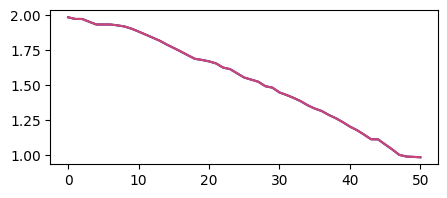

In [359]:
w_var_array = np.array(w_var)

cmap = cm.plasma
fig, ax =plt.subplots(figsize=(5,2))

for t in range(T):
    ax.plot(np.mean(ws_array, axis=1), "-", alpha=1, color=cmap(t/T))

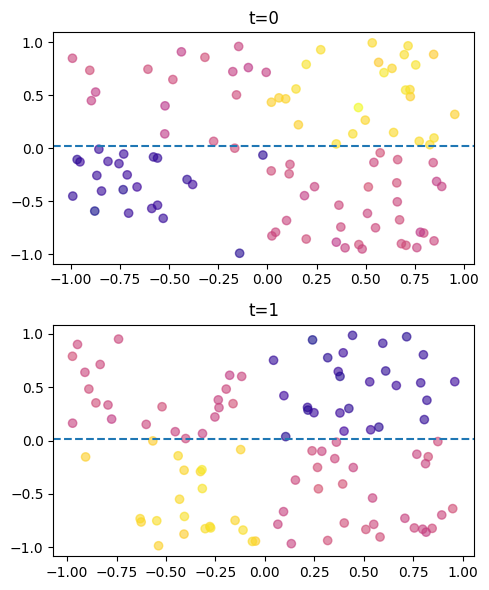

In [360]:
cmap = cm.plasma
fig, ax = plt.subplots(T, figsize=(5, 3*T))
y_min = np.min([np.min(y_list[t]) for t in range(T)])
y_max = np.max([np.max(y_list[t]) for t in range(T)])

for t in range(T):
    ax[t].scatter(X_list[t][:, 0], 
                  X_list[t][:, 1], 
                  c=y_list[t],  # Use c= for color mapping
                  cmap=cmap, 
                  alpha=0.6,
                  vmin=y_min,  # Set color scale limits
                  vmax=y_max)
    ax[t].set_title(f"t={t}")
    if best_feature==0:
        ax[t].axvline(x=best_threshold, ls="--")
    if best_feature==1:
        ax[t].axhline(y=best_threshold, ls="--")
plt.tight_layout()

## Class

### Implementation

In [363]:
class Node:
    def __init__(self, value=None, feature=None, threshold=None, left=None, right=None):
        self.value = value          # For leaf nodes: list of prediction value
        self.feature = feature      # Feature index to split on
        self.threshold = threshold  # Threshold value for split
        self.left = left            # Left child node
        self.right = right          # Right child node
    
    def is_leaf(self):
        return self.value is not None

In [368]:
class SimpleDecisionTreeRegressor:
    def __init__(self, max_depth=3, min_samples=2):
        self.max_depth = max_depth
        self.min_samples = min_samples
        self.root = None
    
    # def fit(self, X_list, y_list):
    #     self.root = self._build_tree(X_list, y_list, depth=0)
    #     return self
    
    def _build_tree(self, X_list, y_list, depth):
        n_samples, n_features = X.shape
        
        # Stopping conditions: make a leaf node
        # depth condition is a bit tricky because nb of samples in X_list[t] 
        # can have different number of rows
        # one could end up with one X_list[t] having many rows
        # and all others having just one
        # this is obviously the price to pay if one wants 
        # to have the same structure
        # there will be some distribution of nb of rows in X_list[t] 
        # and maybe make a decision on the median of nb rows X_list[t]

        n_samples_avg = np.mean([X_list[t].shape[0] for t in range(len(X_list))])
        nb_unique_y_avg = np.mean([len(y_list[t].unique()) for t in range(len(y_list))])
        
        if depth >= self.max_depth or
            n_samples_avg <= self.min_samples or 
            nb_unique_y_avg <= self.nb_y:wwww
            return Node(value=[np.mean([y]))
        
        # Find best split
        best_feature, best_threshold = self._find_best_split(X, y)
        
        # If no good split found, make a leaf
        if best_feature is None:
            return Node(value=np.mean(y))
        
        # Split the data
        left_mask = X[:, best_feature] <= best_threshold
        right_mask = ~left_mask
        
        # Recursively build left and right subtrees
        # left nodel has X_list and y_list masked
        # so that's easy 

        if 0<np.sum(left_mask):
            left_child = self._build_tree(X[left_mask], y[left_mask], depth + 1)
        else:
            left_child = None

        if 0<np.sum(right_mask):
            right_child = self._build_tree(X[right_mask], y[right_mask], depth + 1)
        else:
            right_child = None
        
        return Node(feature=best_feature, threshold=best_threshold, 
                   left=left_child, right=right_child)
    

    def _find_best_split(self, X_list, y_list):
    
        ## number of X and y should coincide
        T = len(y_list)
    
        ## number of features should be 
        ## the same for all t
        p = X_list[0].shape[1]
        
        best_gain = -np.inf
        best_feature = None
        best_threshold = None
        
        parent_variance = np.mean([np.var(y_list[t]) for t in range(T)])
        w_var = []
        
        # Try each feature
        for j in range(p):
            feature_values = np.array([X_list[t][:, j] for t in range(T)]).flatten()
            threshold_list = np.sort(np.unique(feature_values))
        
            for thr in threshold_list:
                weighted_var = np.zeros(T)
                
                for t in range(T):
                    n = X_list[t].shape[0]
                    left_mask = (X_list[t][:,j] <= thr)
                    right_mask = ~left_mask
                    
                    if np.sum(left_mask) != 0 and np.sum(right_mask) != 0:
                        y_left, y_right = y_list[t][left_mask], y_list[t][right_mask]
                        n_left, n_right = len(y_left), len(y_right)
                        
                        weighted_var[t] = (n_left / n) * np.var(y_left) + (n_right / n) * np.var(y_right)                
                    else:
                        weighted_var[t] = np.var(y_list[t])
                
                # Variance reduction (gain)
                gain = parent_variance - np.mean(weighted_var)
                
                # Update best split if this is better
                if gain > best_gain:    
                    best_gain = gain
                    best_feature = j
                    best_threshold = thr
                    
        return best_feature, best_threshold
      
    
#    def predict(self, X):
#        return np.array([self._predict_single(x, self.root) for x in X])
    
#    def _predict_single(self, x, node):
        # If leaf node, return its value
#        if node.is_leaf():
#            return node.value
        
        # Otherwise, go left or right
#        if x[node.feature] <= node.threshold:
#            return self._predict_single(x, node.left)
#        else:
#            return self._predict_single(x, node.right)

### Test

In [369]:
# Generate sample data
#np.random.seed(42)
n, p = 100, 2 # n samples, p features
T = 2

X_list = []
y_list = []

for t in range(T):
    X = np.random.uniform(size=n*p, low=-1, high=1).reshape(n,p)
    y = np.sum(np.sign(X), axis=1) + 0.1*np.random.randn(n) 
    y = y*np.sign(np.random.uniform(size=1, low=-5, high=5)[0])

    X_list.append(X)
    y_list.append(y)

In [370]:
# Train our simple tree
tree = SimpleDecisionTreeRegressor(max_depth=5, min_samples_split=2)
tree._find_best_split(X_list, y_list)

(0, np.float64(-0.01011224019665602))

In [373]:
np.min([1,2,3])

np.int64(1)